In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import numpy as np  # linear algebra
import os
import torch
import torchvision
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torchvision.datasets as datasets  # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
import torch.nn.functional as F  # All functions that don't have any parameters
from torch.utils.data import DataLoader, Dataset  # Gives easier dataset managment and creates mini batches
from torchvision.datasets import ImageFolder
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm


In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # use gpu or cpu

# Load Data

In [7]:
import os
import pickle
breeds = os.listdir("/content/drive/Shareddrives/cse 455/DogBreed/test")
breeds = sorted(breeds)
idx_to_name = dict() # 0: 'African Wild Dog
name_to_idx = dict()

for i in range(len(breeds)):
    idx_to_name[i] = breeds[i]
name_to_idx = {value: key for key, value in idx_to_name.items()}

(idx_to_name, name_to_idx)

with open("/content/drive/Shareddrives/cse 455/DogBreed_models/dog_class_to_name", "wb") as f:
    pickle.dump(idx_to_name, f)

In [ ]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3
DATA_PATH = "/content/drive/Shareddrives/cse 455/DogBreed/"
BATCH_SIZE = 32
SAVE_TO = "/content/drive/Shareddrives/cse 455/DogBreed_models/"

In [ ]:
## add data augmentation
transform_train = transforms.Compose([
transforms.Resize((IMAGE_WIDTH, IMAGE_HEIGHT)),
transforms.RandomCrop(IMAGE_WIDTH, padding=8, padding_mode='edge'), # Take IMAGE_WIDTHxIMAGE_WIDTH crops from padded images
transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
transforms.ToTensor(),
transforms.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))
])


transform_test = transforms.Compose([
transforms.Resize((IMAGE_WIDTH, IMAGE_HEIGHT)),
transforms.ToTensor(),
transforms.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))
])


In [ ]:
data_train = datasets.ImageFolder(DATA_PATH + "train", transform=transform_train)
data_test = datasets.ImageFolder(DATA_PATH + "test", transform=transform_test)
data_val = datasets.ImageFolder(DATA_PATH + "valid", transform=transform_test)


In [ ]:
train_loader = DataLoader(
data_train,
batch_size=BATCH_SIZE,
shuffle=True,
num_workers=2
)

val_loader = DataLoader(
data_val,
batch_size=BATCH_SIZE,
shuffle=False,
num_workers=2

)

test_loader = DataLoader(
data_test,
batch_size=BATCH_SIZE,
shuffle=False,
num_workers=2
)

In [ ]:
(len(data_train), len(data_test), len(data_val))


(7976, 700, 700)

In [ ]:
from collections import Counter
print(dict(Counter(data_train.targets)))

{0: 105, 1: 109, 2: 117, 3: 65, 4: 89, 5: 99, 6: 159, 7: 123, 8: 79, 9: 131, 10: 105, 11: 113, 12: 147, 13: 107, 14: 112, 15: 110, 16: 79, 17: 134, 18: 136, 19: 101, 20: 125, 21: 111, 22: 108, 23: 118, 24: 110, 25: 121, 26: 129, 27: 130, 28: 114, 29: 113, 30: 83, 31: 88, 32: 122, 33: 129, 34: 120, 35: 100, 36: 93, 37: 109, 38: 127, 39: 123, 40: 83, 41: 109, 42: 119, 43: 119, 44: 92, 45: 124, 46: 105, 47: 109, 48: 161, 49: 187, 50: 108, 51: 129, 52: 99, 53: 78, 54: 103, 55: 130, 56: 171, 57: 117, 58: 148, 59: 125, 60: 98, 61: 78, 62: 116, 63: 150, 64: 91, 65: 98, 66: 198, 67: 79, 68: 81, 69: 78}


torch.Size([30, 3, 224, 224])


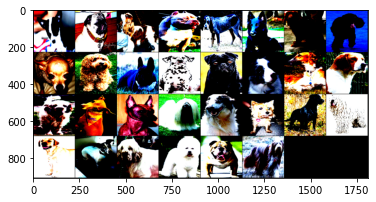

Labels:       22,        58,        11,        55,        13,        50,         4,         4,        22,        26,        36,        31,        58,        14,        15,         7,        25,        41,        52,        49,        15,        21,        48,        46,        48,        41,        25,        10,        20,         8


In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images[:30]
labels = labels[:30]
print(images.size())

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels:" + ', '.join('%9s' % label.item() for label in labels))

# Define Model

In [ ]:

def train(net, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, state=None, schedule={}):
    net.to(DEVICE)
    net.train()
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
    # Load previous training state
    if state:
        net.load_state_dict(state['net'])
        optimizer.load_state_dict(state['optimizer'])
        start_epoch = state['epoch']
        train_losses = state['losses']

    # Fast forward lr schedule through already trained epochs
    for epoch in range(start_epoch):
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

    for epoch in range(start_epoch, epochs):
        sum_loss = 0.0
        train_acc = 0.0
        net.train()

        # Update learning rate when scheduled
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

        loop = tqdm(enumerate(train_loader), total = len(train_loader))
        for i, batch in loop:
          
          inputs, labels = batch[0].to(DEVICE), batch[1].to(DEVICE)

          optimizer.zero_grad()

          outputs = net(inputs)
          loss = criterion(outputs, labels)
          labels_pred_max = torch.argmax(outputs, 1)
          batch_acc = torch.sum(labels_pred_max == labels)
          train_acc = train_acc + batch_acc.item()
          loss.backward()  # autograd magic, computes all the partial derivatives
          optimizer.step() # takes a step in gradient direction

          train_losses.append(loss.item())
          sum_loss += loss.item()
          loop.set_postfix(batch_idx= i, batch_acc= batch_acc.item() /BATCH_SIZE, loss= loss.item())

        # Validation loop; use .no_grad() context manager to save memory.
        train_losses.append(sum_loss / len(train_loader))
        train_accuracies.append(train_acc / (BATCH_SIZE * len(train_loader)))
        net.eval()
        val_loss = 0.0
        val_acc = 0.0
        with torch.no_grad():
          for (v_batch, labels) in val_loader:
              v_batch, labels = v_batch.to(DEVICE), labels.to(DEVICE)
              labels_pred = net(v_batch)
              # v_batch_loss = loss(labels_pred, labels)
              # val_loss = val_loss + v_batch_loss.item()

              v_pred_max = torch.argmax(labels_pred, 1)
              batch_acc = torch.sum(v_pred_max == labels)
              val_acc = val_acc + batch_acc.item()
        val_accuracies.append(val_acc / (BATCH_SIZE * len(val_loader)))
        print("Epoch: {}, val acc: {:.4f}, train loss: {:.4f}, train acc: {:.4f},\n".format(
            epoch, val_accuracies[epoch], train_losses[epoch], train_accuracies[epoch]))
        torch.save(net.state_dict(), SAVE_TO+"DogBreed_ckpt" +  str(epoch)+ ".pt")
    return losses

In [ ]:
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
resnet.fc = nn.Linear(512, 70) # This will reinitialize the layer as well

losses = train(resnet, epochs=5, lr=.01 )

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
100%|██████████| 250/250 [32:09<00:00,  7.72s/it, batch_acc=0.156, batch_idx=249, loss=1.61]


Epoch: 0, val acc: 0.7386, train loss: 4.2959, train acc: 0.6750,



100%|██████████| 250/250 [35:16<00:00,  8.47s/it, batch_acc=0.25, batch_idx=249, loss=0.246]


Epoch: 1, val acc: 0.8224, train loss: 4.3823, train acc: 0.8153,



100%|██████████| 250/250 [31:57<00:00,  7.67s/it, batch_acc=0.188, batch_idx=249, loss=0.459]


Epoch: 2, val acc: 0.8580, train loss: 4.5929, train acc: 0.8795,



100%|██████████| 250/250 [30:47<00:00,  7.39s/it, batch_acc=0.125, batch_idx=249, loss=0.945]


Epoch: 3, val acc: 0.8438, train loss: 4.4444, train acc: 0.9024,



100%|██████████| 250/250 [30:35<00:00,  7.34s/it, batch_acc=0.188, batch_idx=249, loss=0.818]


Epoch: 4, val acc: 0.8679, train loss: 4.3645, train acc: 0.9134,



NameError: ignored

In [ ]:
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
resnet.fc = nn.Linear(512, 70) # This will reinitialize the layer as well
state = torch.load('/content/drive/Shareddrives/cse 455/DogBreed_models/DogCat_ckpt4.pt')
losses = train(resnet, epochs=7,  lr=.001, state=state)